In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install tqdm

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-w1sg2wyd
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-w1sg2wyd


In [ ]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from keras.models import load_model
import time
from IPython import display
from tqdm import tqdm
import cv2
import pandas as pd

Display image of category 9, ship


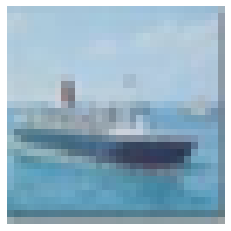

In [ ]:
cats = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Load training images
def load_real_samples():
	(X_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
 
	# Display random images
	index = np.random.randint(0, X_train.shape[0])
	print("Display image of category %d, %s" % (y_train[index][0] + 1, cats[y_train[index][0]]))
	plt.axis('off')
	plt.imshow(X_train[index, :, :, :])

	X_train = (X_train.astype('float32') - 127.5) / 127.5
	dataset = [[] for _ in range(10)]
	for i in range(X_train.shape[0]):
		dataset[y_train[i][0]].append(X_train[i])

	dataset = np.array(dataset)
	return X_train, dataset

def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

org_dataset, dataset = load_real_samples()

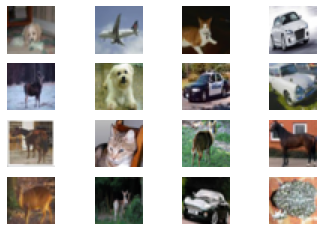

In [ ]:
n = 4
(X_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
for i in range(n * n):
  index = np.random.randint(0, X_train.shape[0])
  plt.subplot(n, n, 1 + i)
  plt.axis('off')
  plt.imshow(X_train[index, :, :, :])

In [ ]:
def define_generator(latent_dim):
	# Fully connected layer from latent_dim (number of noise dimensions) to 1024
	# LeakyReLU, alpha = 0.2
	# Reshape (1024, ) to (4, 4, 256)
	# Convolution upsample layer from (4, 4, 256) to (8, 8, 128)
	# LeakyReLU, alpha = 0.2
	# Convolution upsample layer from (8, 8, 128) to (16, 16, 128)
	# LeakyReLU, alpha = 0.2
	# Convolution upsample layer from (16, 16, 128) to (32, 32, 128)
	# LeakyReLU, alpha = 0.2
	# Convolution layer from (32, 32, 3) to (32, 32, 3) with tanh activation

	"""
	model = tf.keras.Sequential()
	model.add(layers.Dense(4*4*256, input_dim=latent_dim))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Reshape((4, 4, 256)))
	model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Conv2D(3, (3, 3), activation='tanh', padding='same'))
	
	"""
	model = tf.keras.Sequential()

	# model.add(layers.Dense(4*4*512, input_shape=(latent_dim, )))
	# model.add(layers.BatchNormalization())
	# model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Reshape((1, 1, 100), input_shape=(latent_dim, )))

	model.add(layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False))
	model.add(layers.LayerNormalization())
	model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
	model.add(layers.LayerNormalization())
	model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
	model.add(layers.LayerNormalization())
	model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
	model.add(layers.LayerNormalization())
	model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh'))
	
	return model
 
latent_dim = 100
model = define_generator(latent_dim)
model.summary()
#tf.keras.utils.plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 512)        819200    
 nspose)                                                         
                                                                 
 layer_normalization (LayerN  (None, 2, 2, 512)        1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4, 4, 256)        2097152   
 ranspose)                                                       
                                                        

In [ ]:
def define_discriminator(in_shape=(32,32,3)):
	# Convolution layer from (32, 32, 3) to (32, 32, 64)
	# LeakyReLU, alpha = 0.2
	# Convolution layer from (32, 32, 64) to (16, 16, 128)
	# LeakyReLU, alpha = 0.2
	# Convolution layer from (16, 16, 128) to (8, 8, 128)
	# LeakyReLU, alpha = 0.2
	# Convolution layer from (8, 8, 128) to (4, 4, 256)
	# LeakyReLU, alpha = 0.2
	# Flatten Layer from (4, 4, 256) to (1024, )
	# Dropout Layer (Regularization)
	# Fully connected layer from 1024 to 1

	"""
	model = tf.keras.Sequential()
	model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Flatten())
	model.add(layers.Dropout(0.4))
	model.add(layers.Dense(1, activation='sigmoid'))
	"""

	model = tf.keras.Sequential()
 
	model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=in_shape, use_bias=True))
	# model.add(layers.BatchNormalization())
	model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=True))
	# model.add(layers.BatchNormalization())
	model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=True))
	# model.add(layers.BatchNormalization())
	model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=True))
	# model.add(layers.BatchNormalization())
	model.add(layers.LeakyReLU(alpha=0.2))

	model.add(layers.Flatten())
	# model.add(layers.Dropout(0.4))
	model.add(layers.Dense(1, activation='sigmoid'))

	# model.add(layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False))
	# model.add(layers.Dense(1, activation='sigmoid'))

	opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
model = define_discriminator()
model.summary()
#tf.keras.utils.plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 512)        

In [ ]:
def define_gan(g_model, d_model):

	d_model.trainable = False

	model = tf.keras.Sequential()
	model.add(g_model)
	model.add(d_model)

	opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
 
	return model

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
# Generate and save n*n images
def save_plot(examples, cat, epoch, n=7):

	examples = (examples + 1) / 2.0
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
	
	filename = 'cat%d/generated_plot_cat%d_e%03d.png' % (cat+1, cat+1, epoch+1)
	plt.savefig(filename)
	plt.close()

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, cat, latent_dim, n_samples=150):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, cat, epoch)
  filename = 'cat%d/generator_model_cat%d_%03d.h5' % (cat+1, cat+1, epoch+1)
  g_model.save(filename)

In [ ]:
def train(g_model, d_model, gan_model, dataset, cat, latent_dim, n_epochs=100, n_batch=128, print_every=100):
	bat_per_epo = int(dataset.shape[0] / n_batch)	# 5000 / 128
	half_batch = int(n_batch / 2)

	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
	 
			if cat == -1:
				if (j+1) % print_every == 0:
					print('Epoch%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

		# Summarize loss on current epoch
		if cat == -1:
			print('Epoch%d, d1=%.3f, d2=%.3f g=%.3f\n' % (i+1, d_loss1, d_loss2, g_loss))
		else:
			print('Category %s, Epoch%d, d1=%.3f, d2=%.3f g=%.3f' % (cats[cat], i+1, d_loss1, d_loss2, g_loss))
	 
		if(i+1)%5==0:
			print()
			summarize_performance(i, g_model, d_model, dataset, cat, latent_dim)
			print()


In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

# train(g_model, d_model, gan_model, org_dataset, -1, latent_dim)

train(g_model, d_model, gan_model, dataset[9], 9, latent_dim)



In [ ]:
!zip -r /content/drive/MyDrive/cat10.zip /content/cat10/

# from google.colab import files
# files.download("/content/colab.zip")

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/project/
%ls

(50, 32, 32, 3)


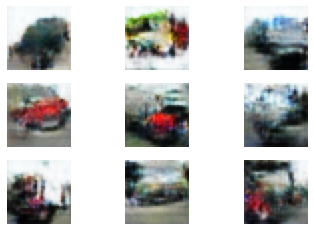

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
def create_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :])
	plt.show()
 
# model = g_model
# model = load_model('lr_0_0002/cat1/generator_model_cat1_080.h5')
model = load_model('latest/cat10/generator_model_cat10_100.h5')
latent_points = generate_latent_points(100, 50)
X = model.predict(latent_points)
X = (X + 1) / 2.0
print(X.shape)

create_plot(X, 3)

In [ ]:
def save_imgs(cat, model_name, num_imgs=6000):
  model = load_model(model_name)
  latent_points = generate_latent_points(100, num_imgs)
  X = model.predict(latent_points)
  X = (X + 1) / 2.0
  print(X.shape)

  for i in tqdm(range(num_imgs)):
    plt.axis('off')
    plt.imshow(X[i, :, :, :])
    # plt.show()
    filename = 'img/cat%d_img/img%04d.png' % (cat+1, i+1)
    plt.savefig(filename)
    plt.close()

# cat1_080
# cat2_100
# cat3_100
# cat4_090
# cat5 100
# cat6 85
# cat7 100
# cat8 100
# cat9 100
# cat10 100
# save_imgs(0, 'latest/cat1/generator_model_cat1_080.h5')
# save_imgs(1, 'latest/cat2/generator_model_cat2_100.h5')
# save_imgs(2, 'latest/cat3/generator_model_cat3_100.h5')
# save_imgs(3, 'latest/cat4/generator_model_cat4_090.h5')
# save_imgs(4, 'latest/cat5/generator_model_cat5_100.h5')
# save_imgs(5, 'latest/cat6/generator_model_cat6_085.h5')
# save_imgs(6, 'latest/cat7/generator_model_cat7_100.h5')
# save_imgs(7, 'latest/cat8/generator_model_cat8_100.h5')
# save_imgs(8, 'latest/cat9/generator_model_cat9_100.h5')
save_imgs(9, 'latest/cat10/generator_model_cat10_100.h5')

# FID

In [ ]:
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10

In [ ]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		new_image = resize(image, new_shape, 0)
		images_list.append(new_image)
	return asarray(images_list)

def calculate_fid(model, images1, images2):
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	ssdiff = np.sum((mu1 - mu2)**2.0)
	covmean = sqrtm(sigma1.dot(sigma2))

	if iscomplexobj(covmean):
		covmean = covmean.real

	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
generated_dataset = pd.read_csv("Z.csv", delimiter=',', header=None)
Z_y = pd.DataFrame(generated_dataset).to_numpy()[:, 0].astype('int')
Z = pd.DataFrame(generated_dataset).to_numpy()[:, 1:].astype('int')
Z = Z.reshape((Z.shape[0], 32, 32, 3))

# Please do not modify Z and Z_y.
# Make a duplicate before you do so.

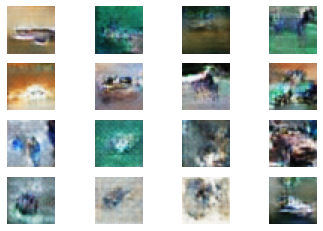

In [ ]:
n = 4
for i in range(n * n):
  index = np.random.randint(0, Z.shape[0])
  plt.subplot(n, n, 1 + i)
  plt.axis('off')
  plt.imshow(Z[index, :, :, :])

In [ ]:
FID_BATCHSIZE = 2000

# load cifar10 images
for cat in range(len(cats)):
  # prepare the inception v3 model
  model = InceptionV3(include_top=False, pooling='avg', input_shape=(96,96,3))

  images1 = dataset[cat][:FID_BATCHSIZE]
  images2 = Z[6000*cat:6000*cat+FID_BATCHSIZE, :, :, :]

  """
  for img in tqdm(os.listdir(path)):
    if num == 1000:
      break
    
    try:
      img_array = cv2.imread(os.path.join(path, img))[35:251, 113:329]
      new_array = cv2.resize(img_array, (32, 32))
      images2.append(new_array)
    except Exception as e:
      print(path + '/' + img + ' cannot be read')
    
    num = num + 1

  images2 = np.array(images2)
  """
  
  images2 = (images2.astype('float32') - 127.5) / 127.5 

  # resize images
  images1 = scale_images(images1, (96,96,3))
  images2 = scale_images(images2, (96,96,3))
  print('Scaled', images1.shape, images2.shape)

  # pre-process images
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  
  # calculate fid
  fid = calculate_fid(model, images1, images2)
  print('Cat%d, FID: %.3f' % (cat+1, fid))

87924736/87910968 [==============================] - 1s 0us/step
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat1, FID: 65.113
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat2, FID: 38.060
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat3, FID: 73.156
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat4, FID: 52.456
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat5, FID: 48.013
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat6, FID: 37.978
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat7, FID: 40.173
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat8, FID: 51.377
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat9, FID: 32.909
Scaled (2000, 96, 96, 3) (2000, 96, 96, 3)
Cat10, FID: 27.774


# CNN Section

In [ ]:
def get_CIFAR10_data(num_training=45000, num_validation=5000, num_test=10000):

    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test
  
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
y_train = tf.keras.utils.to_categorical(y_train,10)
y_val = tf.keras.utils.to_categorical(y_val,10)
y_test = tf.keras.utils.to_categorical(y_test,10)

X_train = (X_train.astype('float32') - 127.5) / 127.5 
X_val = (X_val.astype('float32') - 127.5) / 127.5 
X_test = (X_test.astype('float32') - 127.5) / 127.5 

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (45000, 32, 32, 3)
Train labels shape:  (45000, 10)
Validation data shape:  (5000, 32, 32, 3)
Validation labels shape:  (5000, 10)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 10)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                        

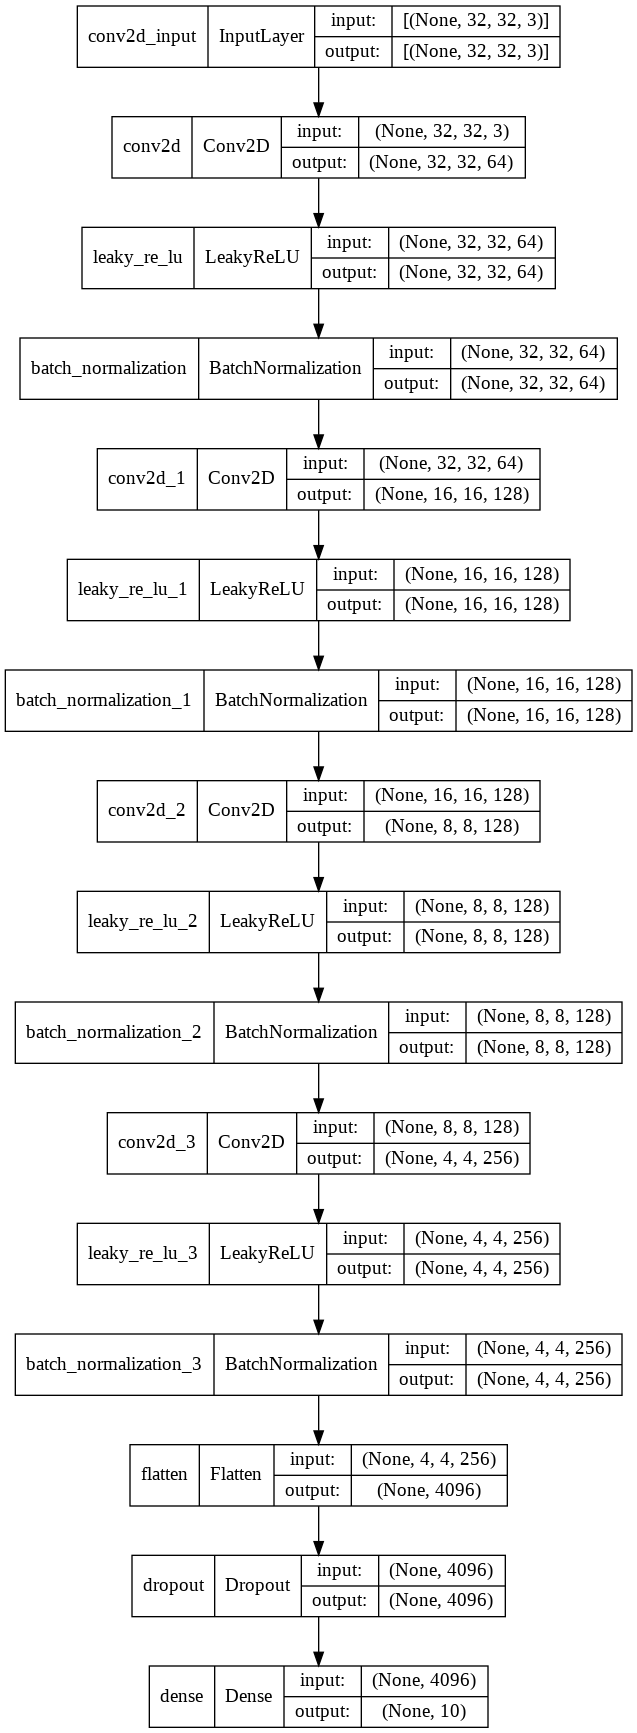

In [ ]:
features = 10
def simple_cnn(in_shape=(32,32,3)):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(features, activation='sigmoid'))
    return model

test_cnn = simple_cnn()
test_cnn.summary()
tf.keras.utils.plot_model(test_cnn, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

# Prepare Generated Data set

In [ ]:

# Prepare Generated Data set

Z_train = (Z[:4500, :, :, :].astype('float32') - 127.5) / 127.5 
Z_y_train = Z_y[:4500]
Z_val = (Z[4500:5000, :, :, :].astype('float32') - 127.5) / 127.5 
Z_y_val = Z_y[4500:5000]
Z_test = (Z[5000:6000, :, :, :].astype('float32') - 127.5) / 127.5 
Z_y_test = Z_y[5000:6000]

for i in range(1, 10):
  Z_train = np.vstack((Z_train, (Z[6000*i:6000*i+4500, :, :, :].astype('float32') - 127.5) / 127.5 ))
  Z_y_train = np.concatenate((Z_y_train, Z_y[6000*i:6000*i+4500]))
  Z_val = np.concatenate((Z_val, (Z[6000*i+4500:6000*i+5000, :, :, :].astype('float32') - 127.5) / 127.5 ))
  Z_y_val = np.concatenate((Z_y_val, Z_y[6000*i+4500:6000*i+5000]))
  Z_test = np.concatenate((Z_test, (Z[6000*i+5000:6000*i+6000, :, :, :].astype('float32') - 127.5) / 127.5 ))
  Z_y_test = np.concatenate((Z_y_test, Z_y[6000*i+5000:6000*i+6000]))

print(Z_train.shape, Z_y_train.shape, Z_val.shape, Z_y_val.shape)

# Convert classes to one hot
_Z_y_train = np.zeros((Z_y_train.size, Z_y_train.max() + 1))
_Z_y_train[np.arange(Z_y_train.size), Z_y_train] = 1
Z_y_train = _Z_y_train

_Z_y_val = np.zeros((Z_y_val.size, Z_y_val.max() + 1))
_Z_y_val[np.arange(Z_y_val.size), Z_y_val] = 1
Z_y_val = _Z_y_val

_Z_y_test = np.zeros((Z_y_test.size, Z_y_test.max() + 1))
_Z_y_test[np.arange(Z_y_test.size), Z_y_test] = 1
Z_y_test = _Z_y_test

# Shuffle the arrays

indices = np.arange(Z_train.shape[0])
np.random.shuffle(indices)
shuffledZ_train = Z_train[indices]
shuffledZ_y_train = Z_y_train[indices]

indices = np.arange(Z_val.shape[0])
np.random.shuffle(indices)
shuffledZ_val = Z_val[indices]
shuffledZ_y_val = Z_y_val[indices]

indices = np.arange(Z_test.shape[0])
np.random.shuffle(indices)
shuffledZ_test = Z_test[indices]
shuffledZ_y_test = Z_y_test[indices]

print(shuffledZ_train.shape, shuffledZ_y_train.shape, shuffledZ_val.shape, shuffledZ_y_val.shape, shuffledZ_test.shape, shuffledZ_y_test.shape)


(45000, 32, 32, 3) (45000,) (5000, 32, 32, 3) (5000,)
(45000, 32, 32, 3) (45000, 10) (5000, 32, 32, 3) (5000, 10) (10000, 32, 32, 3) (10000, 10)


## Original CIFAR-10 dataset

In [ ]:
cnn_model = simple_cnn()
cnn_model.summary()

learning_rate = 1e-4
optim = tf.keras.optimizers.Adam(learning_rate)
cnn_model.compile(optimizer=optim,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

filename = 'cnn_org.h5'
cnn_model.save(filename)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_32 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_33 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                    

313/313 - 2s - loss: 0.1474 - accuracy: 0.7176 - 2s/epoch - 6ms/step
0.7175999879837036
313/313 - 2s - loss: 0.2383 - accuracy: 0.5011 - 2s/epoch - 6ms/step
0.5011000037193298


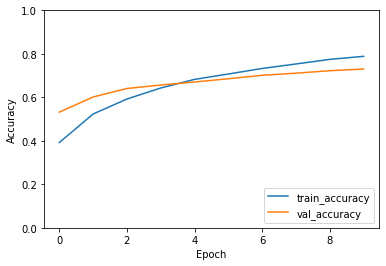

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

test_loss, test_acc = cnn_model.evaluate(shuffledZ_test,  shuffledZ_y_test, verbose=2)
print(test_acc)

Confusion matrix for original CIFAR data 10

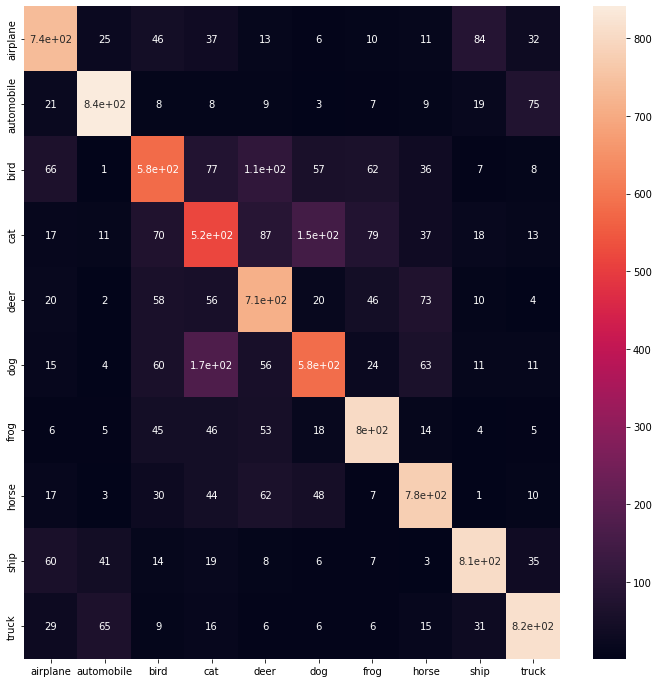

In [ ]:
# X_train, X_test
 
y_pred  = cnn_model.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

cm = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True,  xticklabels=class_names, yticklabels = class_names)

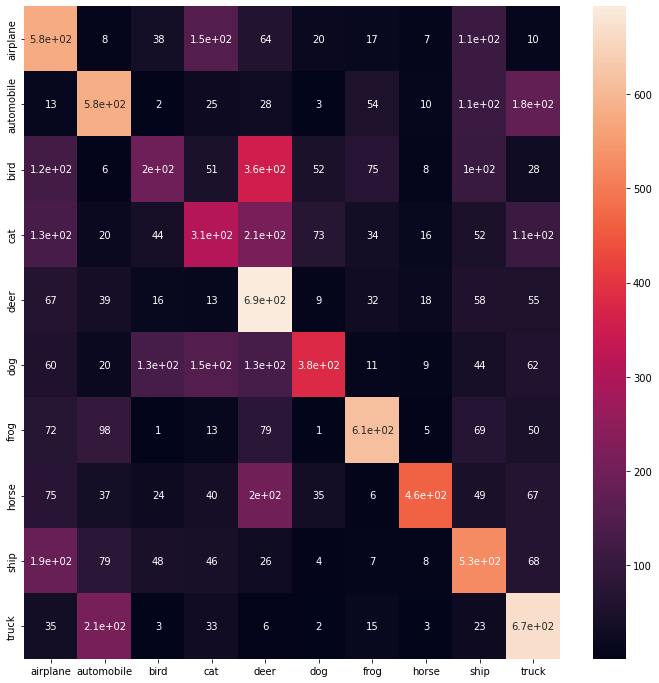

In [ ]:
# X_train, Z_test
 
Zy_pred  = cnn_model.predict(shuffledZ_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

cm = confusion_matrix(shuffledZ_y_test.argmax(axis=1),Zy_pred.argmax(axis=1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True,  xticklabels=class_names, yticklabels = class_names)

## Generated dataset

In [ ]:
cnn_model = simple_cnn()
cnn_model.summary()

learning_rate = 1e-4
optim = tf.keras.optimizers.Adam(learning_rate)
cnn_model.compile(optimizer=optim,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = cnn_model.fit(shuffledZ_train, shuffledZ_y_train, epochs=20, validation_data=(shuffledZ_val, shuffledZ_y_val))

filename = 'cnn_Z.h5'
cnn_model.save(filename)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_48 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_49 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                    

313/313 - 2s - loss: 3.9390e-06 - accuracy: 1.0000 - 2s/epoch - 6ms/step
1.0
313/313 - 2s - loss: 1.5586 - accuracy: 0.1359 - 2s/epoch - 6ms/step
0.13590000569820404


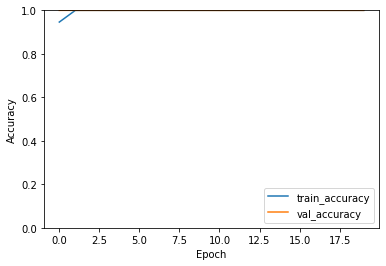

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(shuffledZ_test,  shuffledZ_y_test, verbose=2)
print(test_acc)

test_loss, test_acc = cnn_model.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

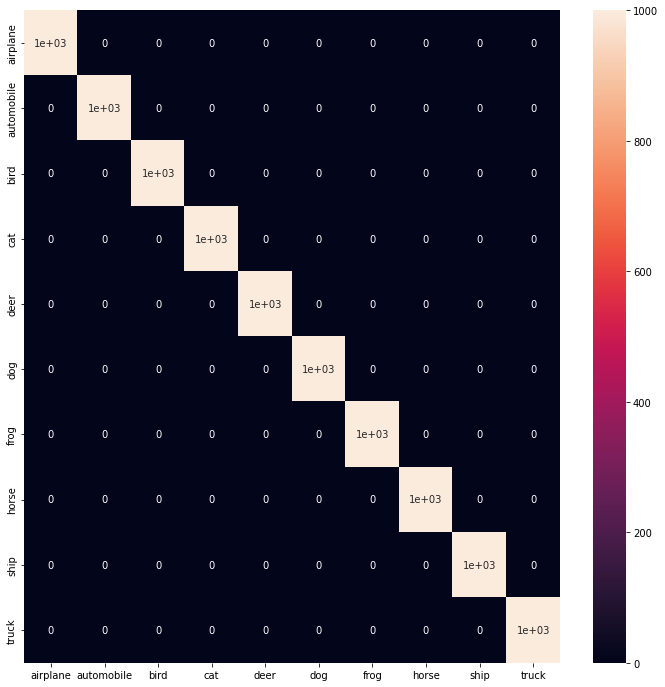

In [ ]:
# Z_train, Z_test
 
Zy_pred  = cnn_model.predict(shuffledZ_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

cm = confusion_matrix(shuffledZ_y_test.argmax(axis=1),Zy_pred.argmax(axis=1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True,  xticklabels=class_names, yticklabels = class_names)

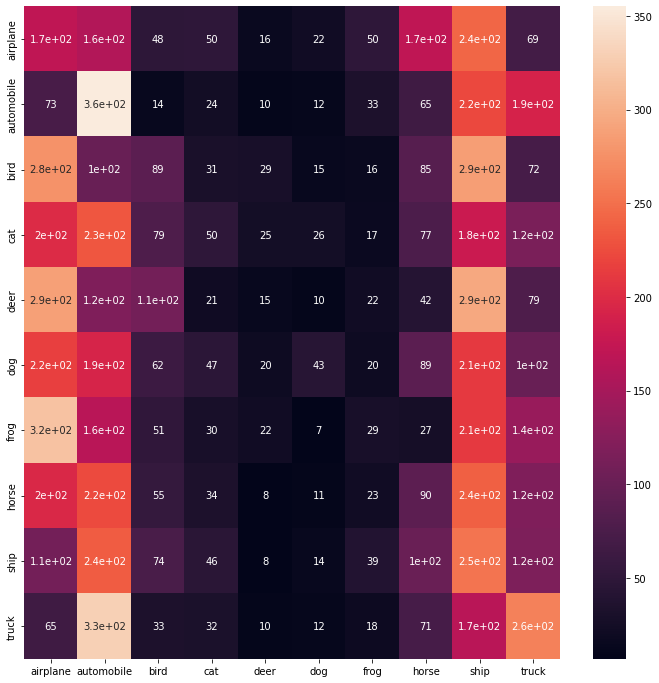

In [ ]:
# Z_train, X_test
 
y_pred  = cnn_model.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

cm = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True,  xticklabels=class_names, yticklabels = class_names)

## Generated + CIFAR-10 dataset

In [ ]:
# Prepare mixed data set

mix_X_train = np.vstack((X_train, shuffledZ_train))
mix_y_train = np.vstack((y_train, shuffledZ_y_train))
mix_X_val = np.vstack((X_val, shuffledZ_val))
mix_y_val = np.vstack((y_val, shuffledZ_y_val))
mix_X_test = np.vstack((X_test, shuffledZ_test))
mix_y_test = np.vstack((y_test, shuffledZ_y_test))

# Shuffle the arrays
indices = np.arange(mix_X_train.shape[0])
np.random.shuffle(indices)
shuffled_mix_X_train = mix_X_train[indices]
shuffled_mix_y_train = mix_y_train[indices]

indices = np.arange(mix_X_val.shape[0])
np.random.shuffle(indices)
shuffled_mix_X_val = mix_X_val[indices]
shuffled_mix_y_val = mix_y_val[indices]

indices = np.arange(mix_X_test.shape[0])
np.random.shuffle(indices)
shuffled_mix_X_test = mix_X_test[indices]
shuffled_mix_y_test = mix_y_test[indices]

print(shuffled_mix_X_train.shape, shuffled_mix_y_train.shape, shuffled_mix_X_val.shape, shuffled_mix_y_val.shape, shuffled_mix_X_test.shape, shuffled_mix_y_test.shape)

(90000, 32, 32, 3) (90000, 10) (10000, 32, 32, 3) (10000, 10) (20000, 32, 32, 3) (20000, 10)


In [ ]:
cnn_model = simple_cnn()
cnn_model.summary()

learning_rate = 1e-4
optim = tf.keras.optimizers.Adam(learning_rate)
cnn_model.compile(optimizer=optim,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = cnn_model.fit(shuffled_mix_X_train, shuffled_mix_y_train, epochs=20, validation_data=(shuffled_mix_X_val, shuffled_mix_y_val))

filename = 'cnn_mix.h5'
cnn_model.save(filename)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                      

In [ ]:
# Idk maybe this will clear some ram

mix_X_train = 0
mix_y_train = 0
mix_X_val = 0
mix_y_val = 0
mix_X_test = 0
mix_y_test = 0

print(shuffled_mix_y_test)  # Debug purpose

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


625/625 - 4s - loss: 0.0971 - accuracy: 0.8546 - 4s/epoch - 6ms/step
0.8545500040054321


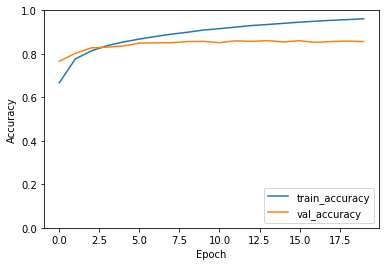

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(shuffled_mix_X_test,  shuffled_mix_y_test, verbose=2)
print(test_acc)

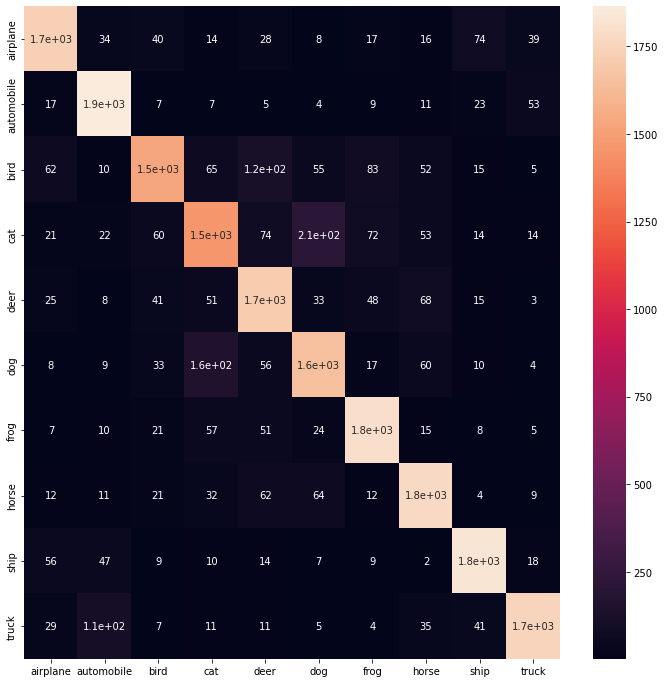

In [ ]:
# mix_X_train, mix_X_test
 
y_pred  = cnn_model.predict(shuffled_mix_X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

cm = confusion_matrix(shuffled_mix_y_test.argmax(axis=1),y_pred.argmax(axis=1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True,  xticklabels=class_names, yticklabels = class_names)